# Misclassification Analysis - Top3 Accuracy

This notebook analyzes misclassifications based on the neighbors structure to determine top3 accuracy.

In [1]:
import pandas as pd
import glob
import os
from collections import defaultdict

# Define neighbors structure
NEIGHBORS = {
    "1A": ["1A", "1B"],
    "1B": ["1A", "1B", "1C"], 
    "1C": ["1B", "1C", "2A"],
    "2A": ["1C", "2A", "2B"],
    "2B": ["2A", "2B", "2C"],
    "2C": ["2B", "2C", "3A"],
    "3A": ["2C", "3A", "3B"],
    "3B": ["3A", "3B", "3C"],
    "3C": ["3B", "3C", "4A"],
    "4A": ["3C", "4A", "4B"],
    "4B": ["4A", "4B", "4C"],
    "4C": ["4B", "4C"]
}

In [2]:
# Find the latest results_evaluation CSV file
csv_files = glob.glob('results_evaluation_*.csv')
if not csv_files:
    raise FileNotFoundError("No results_evaluation CSV files found")

latest_file = max(csv_files, key=os.path.getmtime)
print(f"Loading: {latest_file}")

# Load the evaluation results
df = pd.read_csv(latest_file)
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Loading: results_evaluation_20260209_154747.csv

Dataset shape: (240, 4)
Columns: ['image_path', 'type', 'predicted_label', 'latency']

First few rows:


,image_path,type,predicted_label,latency
0,data/Straight_1a_11.jpg,1A,Unknown,65.599109
1,data/Straight_1a_19.jpg,1A,Unknown,64.416548
2,data/Straight_1A_20.jpg,1A,Unknown,132.126489
3,data/Straight_1a_8.jpg,1A,Unknown,64.280864
4,data/Straight_1a_14.jpg,1A,Unknown,121.785426


In [3]:
def is_top3_correct(true_label, predicted_label, neighbors):
    """
    Check if the predicted label is within the top3 neighbors of the true label.
    
    Args:
        true_label: The actual label
        predicted_label: The predicted label
        neighbors: Dictionary mapping labels to their neighbors
    
    Returns:
        bool: True if prediction is in top3, False otherwise
    """
    if true_label not in neighbors:
        return False
    
    # Get the neighbors for the true label (includes itself)
    valid_predictions = neighbors[true_label]
    
    return predicted_label in valid_predictions


# Apply the function to check top3 accuracy
df['is_top3_correct'] = df.apply(
    lambda row: is_top3_correct(row['type'], row['predicted_label'], NEIGHBORS),
    axis=1
)

# Identify misclassifications (not in top3)
df['is_misclassified'] = ~df['is_top3_correct']

print(f"Total samples: {len(df)}")
print(f"Top3 correct: {df['is_top3_correct'].sum()} ({df['is_top3_correct'].mean()*100:.2f}%)")
print(f"Misclassified (outside top3): {df['is_misclassified'].sum()} ({df['is_misclassified'].mean()*100:.2f}%)")

Total samples: 240
Top3 correct: 0 (0.00%)
Misclassified (outside top3): 240 (100.00%)


In [4]:
# Get all misclassifications
misclassifications = df[df['is_misclassified']].copy()

# Sort by true label and then by predicted label for better organization
misclassifications = misclassifications.sort_values(['type', 'predicted_label'])

print(f"\n{'='*80}")
print(f"MISCLASSIFICATIONS (Outside Top3 Neighbors)")
print(f"{'='*80}\n")
print(f"Total misclassifications: {len(misclassifications)}\n")

# Display all misclassifications
if len(misclassifications) > 0:
    # Show with expected neighbors for context
    misclassifications_display = misclassifications.copy()
    misclassifications_display['expected_top3'] = misclassifications_display['type'].apply(
        lambda x: ', '.join(NEIGHBORS.get(x, []))
    )
    
    print(misclassifications_display[['image_path', 'type', 'predicted_label', 'expected_top3', 'latency']])
else:
    print("No misclassifications found! All predictions are within top3 neighbors.")


MISCLASSIFICATIONS (Outside Top3 Neighbors)

Total misclassifications: 240

                  image_path type predicted_label expected_top3     latency
0    data/Straight_1a_11.jpg   1A         Unknown        1A, 1B   65.599109
1    data/Straight_1a_19.jpg   1A         Unknown        1A, 1B   64.416548
2    data/Straight_1A_20.jpg   1A         Unknown        1A, 1B  132.126489
3     data/Straight_1a_8.jpg   1A         Unknown        1A, 1B   64.280864
4    data/Straight_1a_14.jpg   1A         Unknown        1A, 1B  121.785426
..                       ...  ...             ...           ...         ...
235      data/new_4C_20.jpeg   4C         Unknown        4B, 4C   64.472334
236      data/new_4C_16.jpeg   4C         Unknown        4B, 4C  127.457477
237      data/new_4C_19.jpeg   4C         Unknown        4B, 4C   64.304602
238       data/new_4C_3.jpeg   4C         Unknown        4B, 4C  134.167381
239       data/new_4C_8.jpeg   4C         Unknown        4B, 4C   66.543903

[240 rows 

In [5]:
# Create a summary by true label
print(f"\n{'='*80}")
print(f"MISCLASSIFICATION SUMMARY BY TRUE LABEL")
print(f"{'='*80}\n")

misclass_summary = misclassifications.groupby(['type', 'predicted_label']).size().reset_index(name='count')
misclass_summary = misclass_summary.sort_values(['type', 'count'], ascending=[True, False])

for true_label in sorted(misclassifications['type'].unique()):
    label_misclass = misclass_summary[misclass_summary['type'] == true_label]
    if len(label_misclass) > 0:
        print(f"\nTrue Label: {true_label}")
        print(f"Expected top3: {', '.join(NEIGHBORS.get(true_label, []))}")
        print(f"Misclassifications:")
        for _, row in label_misclass.iterrows():
            print(f"  → Predicted as {row['predicted_label']}: {row['count']} times")
        print(f"  Total: {label_misclass['count'].sum()}")


MISCLASSIFICATION SUMMARY BY TRUE LABEL


True Label: 1A
Expected top3: 1A, 1B
Misclassifications:
  → Predicted as Unknown: 20 times
  Total: 20

True Label: 1B
Expected top3: 1A, 1B, 1C
Misclassifications:
  → Predicted as Unknown: 20 times
  Total: 20

True Label: 1C
Expected top3: 1B, 1C, 2A
Misclassifications:
  → Predicted as Unknown: 20 times
  Total: 20

True Label: 2A
Expected top3: 1C, 2A, 2B
Misclassifications:
  → Predicted as Unknown: 20 times
  Total: 20

True Label: 2B
Expected top3: 2A, 2B, 2C
Misclassifications:
  → Predicted as Unknown: 20 times
  Total: 20

True Label: 2C
Expected top3: 2B, 2C, 3A
Misclassifications:
  → Predicted as Unknown: 20 times
  Total: 20

True Label: 3A
Expected top3: 2C, 3A, 3B
Misclassifications:
  → Predicted as Unknown: 20 times
  Total: 20

True Label: 3B
Expected top3: 3A, 3B, 3C
Misclassifications:
  → Predicted as Unknown: 20 times
  Total: 20

True Label: 3C
Expected top3: 3B, 3C, 4A
Misclassifications:
  → Predicted as Unknown: 20

In [6]:
# Export misclassifications to CSV for further analysis
if len(misclassifications) > 0:
    output_file = latest_file.replace('.csv', '_misclassifications_top3.csv')
    
    export_df = misclassifications.copy()
    export_df['expected_top3'] = export_df['type'].apply(
        lambda x: ', '.join(NEIGHBORS.get(x, []))
    )
    
    # Reorder columns for better readability
    columns_order = ['image_path', 'type', 'predicted_label', 'expected_top3', 
                     'is_top3_correct', 'is_misclassified', 'latency']
    export_df = export_df[columns_order]
    
    export_df.to_csv(output_file, index=False)
    print(f"\n{'='*80}")
    print(f"Misclassifications exported to: {output_file}")
    print(f"{'='*80}")
else:
    print("\nNo misclassifications to export.")


Misclassifications exported to: results_evaluation_20260209_154747_misclassifications_top3.csv


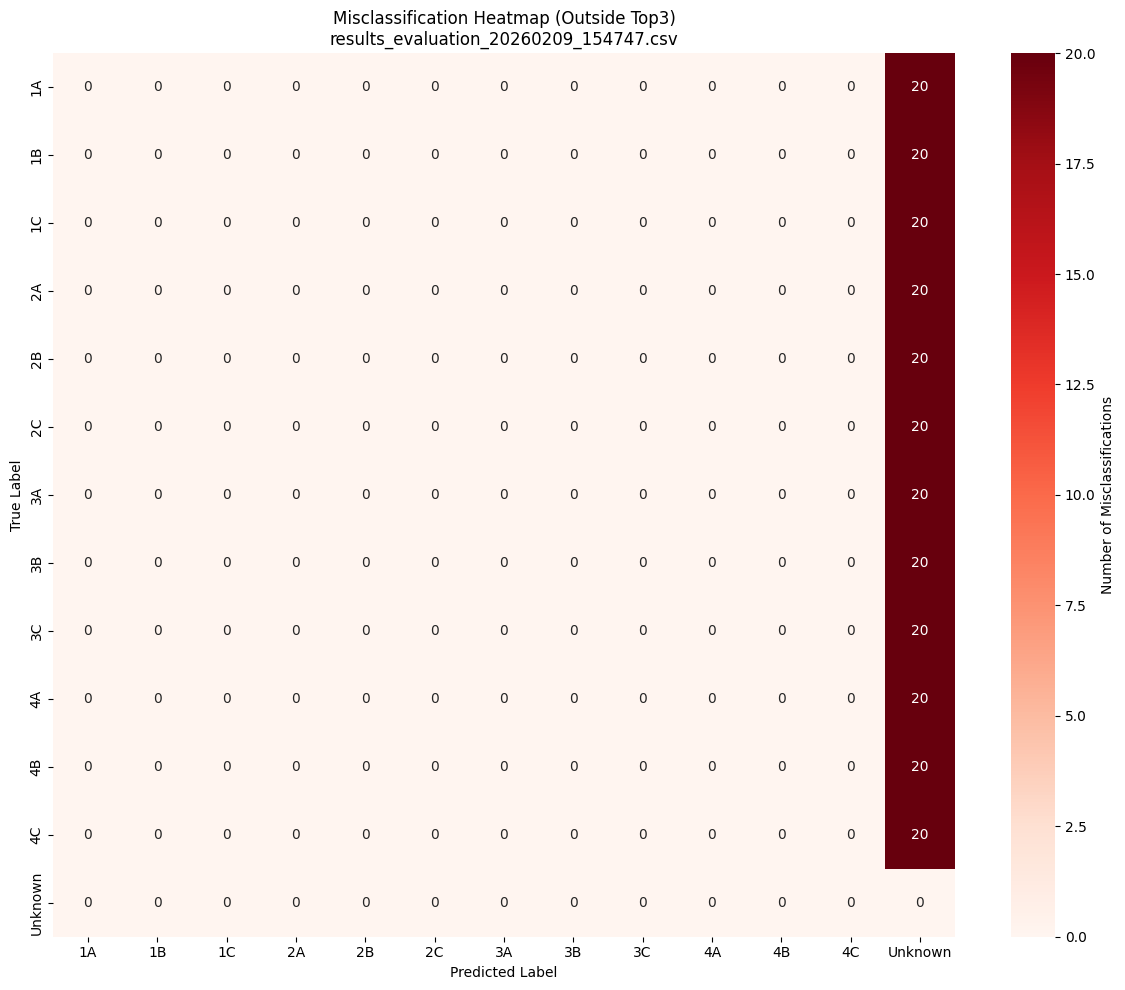


Heatmap saved as: results_evaluation_20260209_154747_misclassifications_heatmap.png


In [7]:
# Visualization: Confusion matrix for misclassifications
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

if len(misclassifications) > 0:
    # Create confusion pairs
    confusion_pairs = list(zip(misclassifications['type'], misclassifications['predicted_label']))
    pair_counts = Counter(confusion_pairs)
    
    # Get all unique labels
    all_labels = sorted(set(df['type'].unique()) | set(df['predicted_label'].unique()))
    
    # Create confusion matrix for misclassifications only
    confusion_matrix = [[0 for _ in all_labels] for _ in all_labels]
    label_to_idx = {label: idx for idx, label in enumerate(all_labels)}
    
    for (true_label, pred_label), count in pair_counts.items():
        true_idx = label_to_idx[true_label]
        pred_idx = label_to_idx[pred_label]
        confusion_matrix[true_idx][pred_idx] = count
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_matrix, 
                annot=True, 
                fmt='d', 
                cmap='Reds',
                xticklabels=all_labels,
                yticklabels=all_labels,
                cbar_kws={'label': 'Number of Misclassifications'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Misclassification Heatmap (Outside Top3)\n{latest_file}')
    plt.tight_layout()
    plt.savefig(latest_file.replace('.csv', '_misclassifications_heatmap.png'), dpi=150)
    plt.show()
    
    print(f"\nHeatmap saved as: {latest_file.replace('.csv', '_misclassifications_heatmap.png')}")
else:
    print("\nNo misclassifications to visualize.")